# 1. Установка и импорт

В этом задании вам предстоит выполнить полный EDA анализ
и ответить на вопросы по результатам анализа.

Для выполнения задания:
1. Изучите данные и выполните весь пайплайн EDA
2. Ответьте на вопросы в конце файла
3. Заполните ответы в словаре answers

In [ ]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from scipy import stats

# Настройки стилей графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 300
})

# 2. Загрузка данных

Данные о страховых случаях

Описание признаков:
- age: возраст клиента
- bmi: индекс массы тела
- children: количество детей/иждивенцев
- charges: стоимость страховки
- smoker: курит ли клиент (yes/no)
- region: регион проживания (southwest, southeast, northwest, northeast)
- insurance_claim: была ли подана страховка (0 - нет, 1 - да)

In [ ]:
np.random.seed(2024)
n_samples = 1000

# Создаем DataFrame
df_insurance = pd.DataFrame({
    'age': np.random.normal(40, 15, n_samples).clip(18, 80).astype(int),
    'bmi': np.random.normal(28, 6, n_samples).clip(15, 50),
    'children': np.random.poisson(1.5, n_samples).clip(0, 5),
    'charges': np.random.exponential(15000, n_samples) + 1000,
    'smoker': np.random.choice(['yes', 'no'], n_samples, p=[0.2, 0.8]),
    'region': np.random.choice(['southwest', 'southeast', 'northwest', 'northeast'],
                               n_samples, p=[0.25, 0.3, 0.25, 0.2]),
    'insurance_claim': np.random.binomial(1, 0.3, n_samples)
})

# Добавляем реалистичные зависимости
df_insurance.loc[df_insurance['smoker'] == 'yes', 'charges'] *= 2.5
df_insurance.loc[df_insurance['age'] > 60, 'charges'] *= 1.3
df_insurance.loc[df_insurance['bmi'] > 35, 'charges'] *= 1.2

# Добавляем пропуски (реалистичный паттерн)
# У курильщиков реже заполнен BMI
smoker_mask = df_insurance['smoker'] == 'yes'
df_insurance.loc[smoker_mask & (np.random.rand(n_samples) < 0.15), 'bmi'] = np.nan

# У пожилых реже заполнены дети
age_mask = df_insurance['age'] > 65
df_insurance.loc[age_mask & (np.random.rand(n_samples) < 0.1), 'children'] = np.nan

# В северо-восточном регионе пропуски в charges
region_mask = df_insurance['region'] == 'northeast'
df_insurance.loc[region_mask & (np.random.rand(n_samples) < 0.08), 'charges'] = np.nan

# Добавляем выбросы
# Выбросы в charges
outlier_indices = np.random.choice(n_samples, 15, replace=False)
df_insurance.loc[outlier_indices, 'charges'] *= 4

# Выбросы в bmi
outlier_indices_bmi = np.random.choice(n_samples, 10, replace=False)
df_insurance.loc[outlier_indices_bmi, 'bmi'] = df_insurance.loc[outlier_indices_bmi, 'bmi'] * 1.8

Задание 1: вывести на экран "шапку", размер датафрейма, количество признаков, представленные типы данных и статистику числовых признаков

In [ ]:
print('Размер датасета:', df_insurance.shape)
print('Количество признаков:', df_insurance.shape[1])
display(df_insurance.head(10))
print('Информация о типах данных:')
print(df_insurance.dtypes, '\n')
print('Базовая статистика числовых признаков:')
print(df_insurance.describe())

Размер датасета: (1000, 7)
Количество признаков: 7


,age,bmi,children,charges,smoker,region,insurance_claim
0,65,36.349066,0.0,NaN,no,northeast,1
1,51,28.934381,1.0,2583.734319,no,southeast,0
2,36,25.402012,3.0,53941.526800,yes,northeast,0
3,37,23.954296,2.0,5739.464506,no,northeast,1
4,53,29.530733,1.0,15400.573233,no,southeast,0
5,57,27.974254,0.0,22175.648880,yes,southeast,0
6,18,28.641012,0.0,9480.234180,no,southwest,0
7,20,31.548388,0.0,46261.975814,no,northwest,0
8,46,33.195100,1.0,7975.315155,no,southwest,1
9,41,31.017926,0.0,42029.973864,no,southwest,1


Информация о типах данных:
age                  int64
bmi                float64
children           float64
charges            float64
smoker              object
region              object
insurance_claim      int64
dtype: object 

Базовая статистика числовых признаков:
               age         bmi    children        charges  insurance_claim
count  1000.000000  970.000000  995.000000     983.000000      1000.000000
mean     40.319000   27.990417    1.487437   21395.192439         0.308000
std      14.181479    6.430522    1.193794   23405.226228         0.461898
min      18.000000   15.000000    0.000000    1010.624297         0.000000
25%      30.000000   23.574836    1.000000    6317.168301         0.000000
50%      40.000000   27.987174    1.000000   14823.219149         0.000000
75%      50.000000   32.173417    2.000000   27662.988189         1.000000
max      80.000000   63.652254    5.000000  259808.000964         1.000000


# 3. Анализ пропусков с использованием msno, dropna, isnull

Задание 2: провести анализ по плану

Количество пропусков по признакам:
  age: нет пропусков
  bmi: 30 пропусков (3.0%)
  children: 5 пропусков (0.5%)
  charges: 17 пропусков (1.7%)
  smoker: нет пропусков
  region: нет пропусков
  insurance_claim: нет пропусков


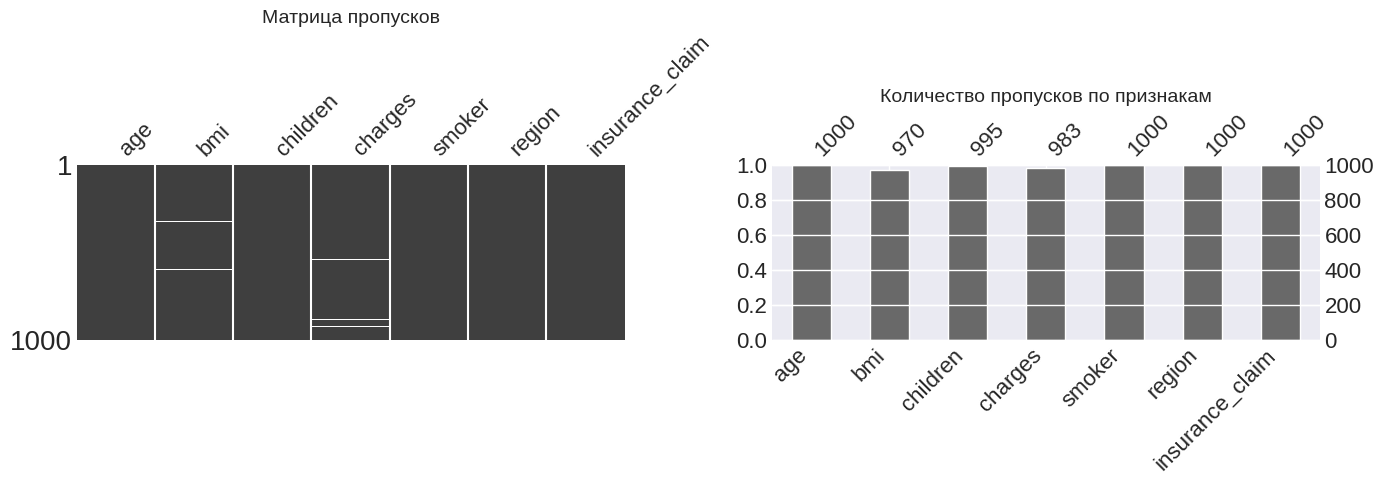

Анализ с использованием dropna():
Исходный размер: (1000, 7)
После dropna() (удаление всех строк с пропусками): (948, 7)
После dropna(axis=1) (удаление колонок с пропусками): (1000, 4)
После dropna(thresh=6): (1000, 7)


In [ ]:
# 1. Используем isnull для подсчета пропусков
missing_data = df_insurance.isnull().sum()
missing_percent = (missing_data / len(df_insurance)) * 100

print("Количество пропусков по признакам:")
for col in df_insurance.columns:
    if missing_data[col] > 0:
        print(f"  {col}: {missing_data[col]} пропусков ({missing_percent[col]:.1f}%)")
    else:
        print(f"  {col}: нет пропусков")

# 2. Визуализация пропусков с помощью msno
#       - Матрица пропусков
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
msno.matrix(df_insurance, ax=axes[0], sparkline=False)
axes[0].set_title('Матрица пропусков')

#       - Bar chart пропусков
msno.bar(df_insurance, ax=axes[1])
axes[1].set_title('Количество пропусков по признакам')

plt.tight_layout()
plt.show()

# 3. Применение dropna для анализа
#       - Разные стратегии удаления пропусков: все строки, все столбцы, с порогом
print("Анализ с использованием dropna():")
print(f"Исходный размер: {df_insurance.shape}")

# dropna с разными стратегиями
df_dropped_all = df_insurance.dropna()
print(f"После dropna() (удаление всех строк с пропусками): {df_dropped_all.shape}")

df_dropped_cols = df_insurance.dropna(axis=1)
print(f"После dropna(axis=1) (удаление колонок с пропусками): {df_dropped_cols.shape}")

# dropna с threshold
df_dropped_thresh = df_insurance.dropna(thresh=round(len(df_insurance.columns)*0.8)) # оставляем строки с хотя бы 80% заполненных значений
print(f"После dropna(thresh={round(len(df_insurance.columns)*0.8)}): {df_dropped_thresh.shape}")

# 4. Визуализация с boxplot и iqr

Задание 3: визуализируйте числовые признаки с boxplot и посчитывайте выбросы с iqr

Числовые признаки: ['age', 'bmi', 'children', 'charges', 'insurance_claim']



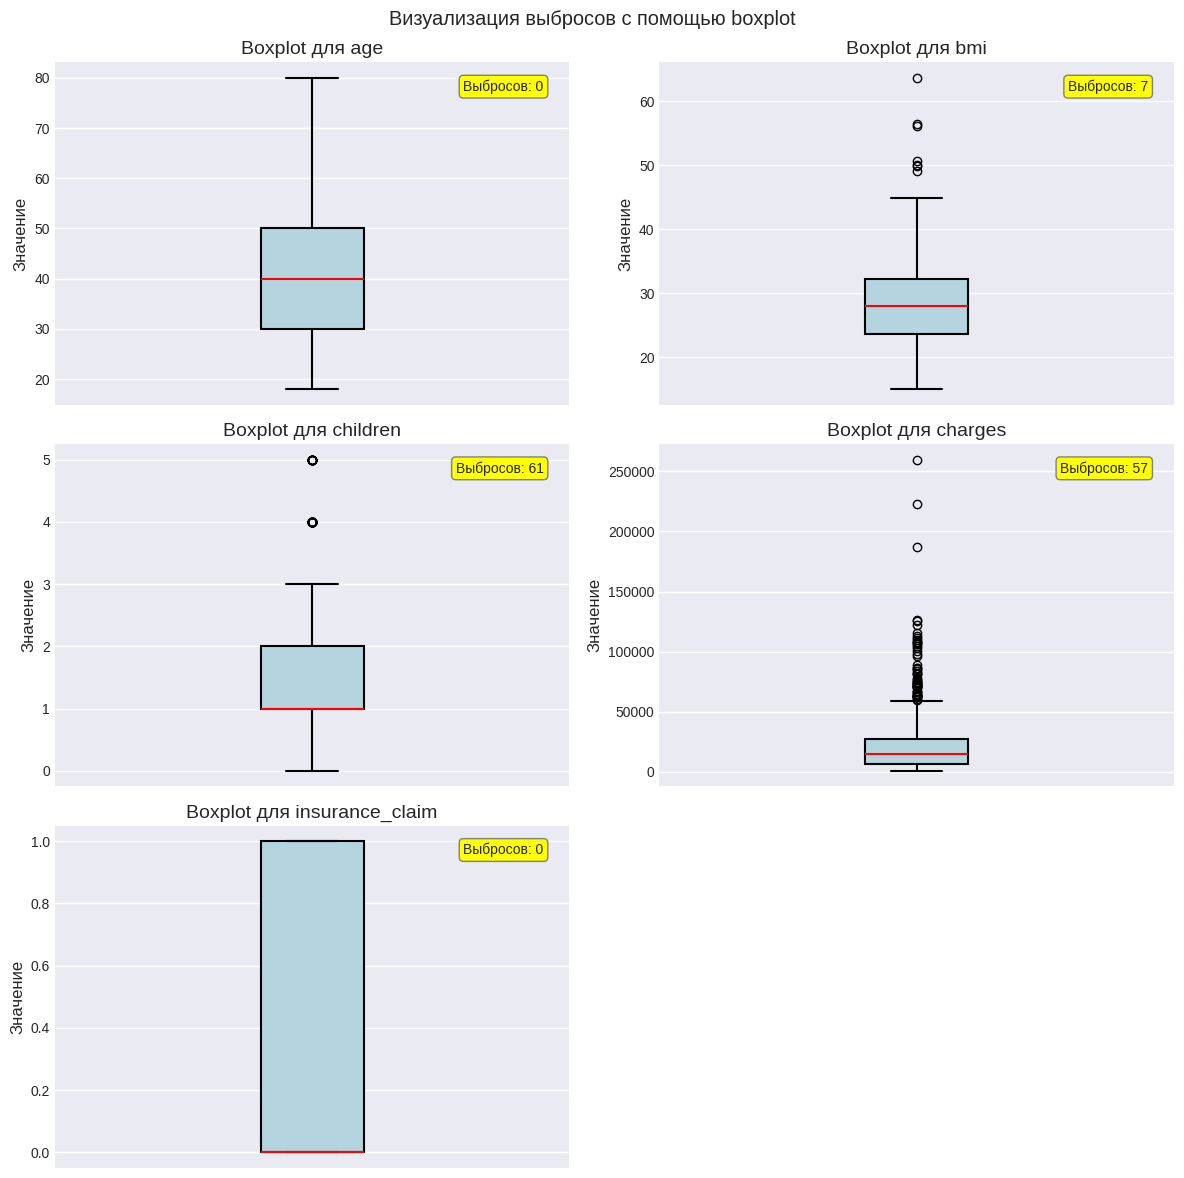


Обнаружение выбросов методом IQR:

age:
  Q1: 30.00, Q3: 50.00, IQR: 20.00
  Границы: [0.00, 80.00]
  Выбросов: 0 (0.0%)

bmi:
  Q1: 23.57, Q3: 32.17, IQR: 8.60
  Границы: [10.68, 45.07]
  Выбросов: 7 (0.7%)
  Min выброс: 49.10
  Max выброс: 63.65

children:
  Q1: 1.00, Q3: 2.00, IQR: 1.00
  Границы: [-0.50, 3.50]
  Выбросов: 61 (6.1%)
  Min выброс: 4.00
  Max выброс: 5.00

charges:
  Q1: 6317.17, Q3: 27662.99, IQR: 21345.82
  Границы: [-25701.56, 59681.72]
  Выбросов: 57 (5.8%)
  Min выброс: 60126.27
  Max выброс: 259808.00

insurance_claim:
  Q1: 0.00, Q3: 1.00, IQR: 1.00
  Границы: [-1.50, 2.50]
  Выбросов: 0 (0.0%)


In [ ]:
# Выбираем числовые признаки для анализа
numeric_cols = df_insurance.select_dtypes(include=[np.number]).columns
print(f"Числовые признаки: {numeric_cols.to_list()}\n")

# Применяем IQR для количественного анализа
def detect_outliers_iqr(series):
    """Обнаружение выбросов методом IQR"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = series[(series < lower_bound) | (series > upper_bound)]

    return {
        'q1': Q1,
        'q3': Q3,
        'iqr': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers': outliers,
        'n_outliers': len(outliers),
        'percent_outliers': len(outliers) / len(series) * 100
    }

results = [detect_outliers_iqr(df_insurance[col].dropna()) for col in numeric_cols]

# Создаем subplots для ящиков с усами
fig, axes = plt.subplots(len(numeric_cols) // 2 + len(numeric_cols) % 2, 2, figsize=(12, 12))
# При нечетном количестве признаков удаляем один subplot
if len(numeric_cols) % 2 == 1:
    fig.delaxes(axes.flatten()[-1])

# Визуализация выбросов с помощью boxplot
fig.suptitle("Визуализация выбросов с помощью boxplot")
for idx, col in enumerate(numeric_cols):
    ax = axes[idx // 2, idx % 2]
    sns.boxplot(y=df_insurance[col].dropna(), ax=ax,
                width=0.2, color='lightblue',
                linecolor='black', linewidth=1.5,
                medianprops={"color": "red"})
    ax.set_title(f'Boxplot для {col}')
    ax.set_ylabel('Значение')
    # Добавляем подписи с количеством выбросов
    ax.text(0.95, 0.95,
            f"Выбросов: {results[idx]["n_outliers"]}",
            transform=ax.transAxes,
            horizontalalignment='right',
            verticalalignment='top',
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor='yellow', edgecolor='gray'))

plt.tight_layout()
plt.show()

# Вывод результатов IQR
print('\nОбнаружение выбросов методом IQR:')
for idx, col in enumerate(numeric_cols):
    print(f"\n{col}:")
    result = results[idx]
    print(f"  Q1: {result['q1']:.2f}, Q3: {result['q3']:.2f}, IQR: {result['iqr']:.2f}")
    print(f"  Границы: [{result['lower_bound']:.2f}, {result['upper_bound']:.2f}]")
    print(f"  Выбросов: {result['n_outliers']} ({result['percent_outliers']:.1f}%)")

    if result['n_outliers'] > 0:
        print(f"  Min выброс: {result['outliers'].min():.2f}")
        print(f"  Max выброс: {result['outliers'].max():.2f}")

# 5. Анализ распределений и взаимосвязей

Задание 4.1: выполните визуализацию распределений для двух ключевых признаков: charges и bmi, а также постройте кореллограмму

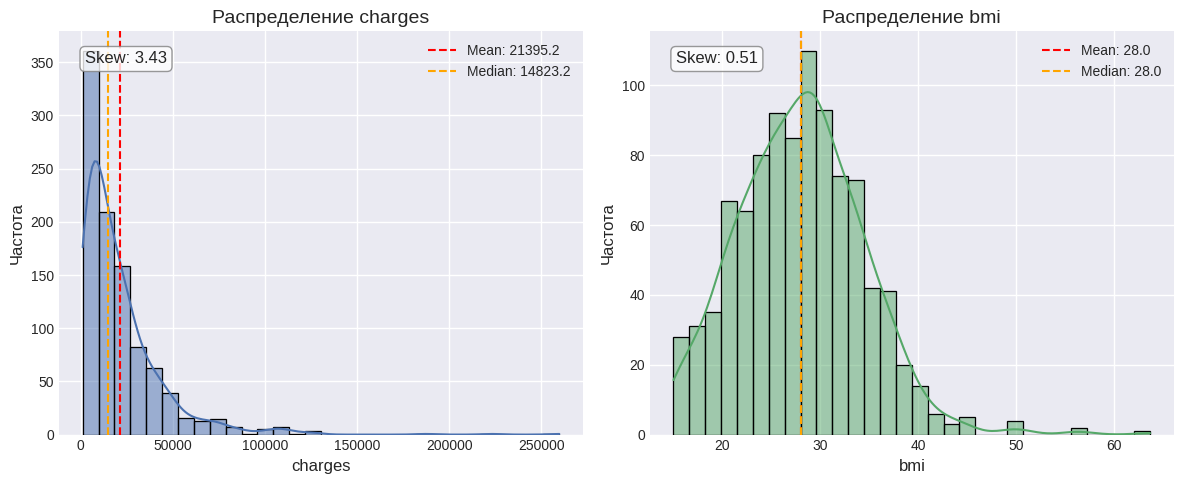

Корреляционная матрица (Пирсон):
                   age    bmi  children  charges  insurance_claim
age              1.000  0.037     0.014    0.006           -0.026
bmi              0.037  1.000     0.030    0.027           -0.032
children         0.014  0.030     1.000   -0.038           -0.029
charges          0.006  0.027    -0.038    1.000           -0.029
insurance_claim -0.026 -0.032    -0.029   -0.029            1.000 



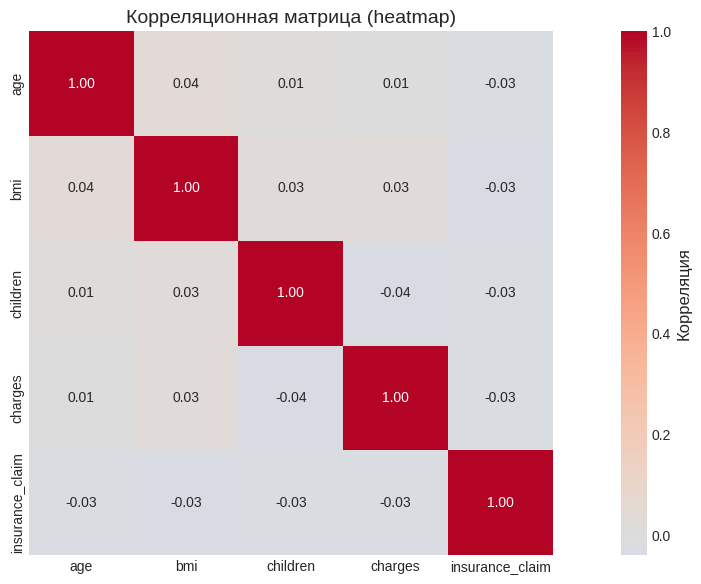

In [ ]:
# Визуализация распределений для двух ключевых признаков
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Гистограмма для charges
ax = axes[0]
sns.histplot(df_insurance['charges'].dropna(), kde=True, ax=ax,
             bins=30, edgecolor='black', color='b')
ax.set_title(f'Распределение charges')
ax.set_xlabel('charges')
ax.set_ylabel('Частота')

# Добавляем статистики для charges (mean, median, skew)
charges_skewness = df_insurance['charges'].skew()
charges_mean = df_insurance['charges'].mean()
charges_median = df_insurance['charges'].median()

ax.text(0.05, 0.95, f'Skew: {charges_skewness:.2f}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
ax.axvline(charges_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {charges_mean:.1f}')
ax.axvline(charges_median, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {charges_median:.1f}')
ax.legend(loc='upper right')

# Гистограмма для bmi
ax = axes[1]
sns.histplot(df_insurance['bmi'].dropna(), kde=True, ax=ax,
             bins=30, edgecolor='black', color='g')
ax.set_title(f'Распределение bmi')
ax.set_xlabel('bmi')
ax.set_ylabel('Частота')

# Добавляем статистики для bmi (mean, median, skew)
bmi_skewness = df_insurance['bmi'].skew()
bmi_mean = df_insurance['bmi'].mean()
bmi_median = df_insurance['bmi'].median()

ax.text(0.05, 0.95, f'Skew: {bmi_skewness:.2f}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
ax.axvline(bmi_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {bmi_mean:.1f}')
ax.axvline(bmi_median, color='orange', linestyle='--', linewidth=1.5, label=f'Median: {bmi_median:.1f}')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Расчет и вывод на экран корреляционной матрицы
correlation_matrix = df_insurance[numeric_cols].corr()

print("Корреляционная матрица (Пирсон):")
print(correlation_matrix.round(3), "\n")

fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# Коррелограмма (heatmap)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f',
            annot_kws={"size": 10},
            cmap='coolwarm', center=0, ax=axes,
            square=True, cbar_kws={'label': 'Корреляция'})
axes.set_title('Корреляционная матрица (heatmap)')

plt.tight_layout()
plt.show()

Задание 4.2: ответить на вопросы

```
Вопрос 1: Какие выводы можно сделать о пропущенных данных?
A) Больше всего пропусков в признаке 'charges'
B) Пропуски случайно распределены по датасету
C) Пропуски в 'bmi' связаны с признаком 'smoker'
D) Все признаки имеют примерно одинаковый процент пропусков

Вопрос 2: Какой подход к обработке пропусков НАИБОЛЕЕ подходит для этого датасета?
A) Удалить все строки с пропусками
B) Удалить все колонки с пропусками
C) Заполнить пропуски медианными значениями
D) Использовать продвинутые методы импутации на основе других признаков

Вопрос 3: Что показывают boxplot для 'charges'?
A) Распределение нормальное, без выбросов
B) Много выбросов в верхней части (высокие значения)
C) Выбросы только в нижней части
D) Распределение симметричное

Вопрос 4: Какой признак имеет НАИБОЛЬШЕЕ влияние на целевую переменную 'insurance_claim'?
A) age (возраст)
B) bmi (индекс массы тела)
C) charges (стоимость страховки)
D) children (количество детей)

Вопрос 5: Какова природа корреляции между 'age' и 'charges'?
A) Отрицательная сильная корреляция
B) Положительная умеренная корреляция
C) Нет значимой корреляции
D) Нелинейная зависимость
```

**Ответы**

`C, A, B, B, C`